In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [3]:
data = pd.read_csv('../../../data/train/angular_ts.csv')
data.head(5)

(44666, 6)

In [4]:
data_test = pd.read_csv('../../../data/test/components_ts.csv')
data_test.head(5)

In [ ]:
################## making dataset_vec ##################

import pandas as pd

def parse_file_name(name):
    # file name pattern: name_commitId_before/after.ts

    index = name.rfind('_')
    file_type = name[index+1:-3]

    name = name[:index]
    index = name.rfind('_')
    commit_id = name[index+1:]

    name = name[17:index]

    index = name.find(':')
    if index != -1:
        name = name.replace(':', '/')

    return name, commit_id, file_type


def vec_to_float(list):
    list_float = [float(l) for l in list]
    return list_float


def get_file_vectors(tokens_file, vectors_file):
    with open(tokens_file, 'r') as tokens, \
            open(vectors_file, 'r') as vectors:
        tokens = tokens.read().splitlines()
        vectors_list = vectors.read().splitlines()

        names = []
        for i in range(0, len(tokens)):
            if i % 2 == 0:
                if tokens[i].startswith('raw_data/val_dir'):
                    names.append(tokens[i])


    filenames = []
    commits = []
    types = []

    for name in names:
        filename, commit_id, file_type = parse_file_name(name)
        filenames.append(filename)
        commits.append(commit_id)
        types.append(file_type)

    file_vectors = []

    for i in range(0, len(names)):
        vector_list = vectors_list[i].split()
        vector_list = vec_to_float(vector_list)

        same_file = [file for file in file_vectors
                   if (file.get('name') == filenames[i] and file.get('commit_id') == commits[i])]

        if same_file:
            if types[i] == 'before':
                same_file[0]['vector_before'] = vector_list
            elif types[i] == 'after':
                same_file[0]['vector_after'] = vector_list
        else:
            if types[i] == 'before':
                file_vec = {'name': filenames[i], 'commit_id': commits[i], 'vector_before': vector_list}
            elif types[i] == 'after':
                file_vec = {'name': filenames[i], 'commit_id': commits[i], 'vector_after': vector_list}
            file_vectors.append(file_vec)

    return file_vectors


file_vectors = get_file_vectors('../../../data/train/vectors_data/val_raw.txt', '../../../data/train/vectors_data/ts_dataset.val.c2v.vectors')
file_test_vectors = get_file_vectors('../../../data/test/vectors_data/components_vectors/val_raw.txt',
                                     '../../../data/test/vectors_data/components_vectors/ts_dataset.val.c2v.vectors')

data_vectors = pd.DataFrame(file_vectors)
data_test_vectors = pd.DataFrame(file_test_vectors)

data_vectors = data_vectors.fillna(0)
data_test_vectors = data_test_vectors.fillna(0)

data_vectors = data_vectors.rename(columns={'name': 'file_name'})
data_test_vectors = dadata_test_vectors.rename(columns={'name': 'file_name'})

merged = pd.merge(left=data, right=data_vectors, on=['file_name', 'commit_id'], how='inner')
merged_test = pd.merge(left=data_test, right=data_test_vectors, on=['file_name', 'commit_id'], how='inner')

In [ ]:
table = merged[['is_added', 'is_deleted', 'is_modified', 'is_renamed', 'file_before', 'file_after', 'commit_type']]
table_test = merged_test[['is_added', 'is_deleted', 'is_modified', 'is_renamed', 'file_before', 'file_after', 'commit_type']]

In [ ]:
data_test = table_test[['file_type', 'file_diff_type', 'file_diff']]
y_data_test = table_test[['commit_type']]

X_train, X_test, y_train, y_test = train_test_split(
    table[['file_type', 'file_diff_type', 'file_diff']],
    table[['commit_type']], test_size=0.2)

In [ ]:
n_neighbors_values = range(1, 50, 5)
scores_data = pd.DataFrame()

In [ ]:
max_depth_values = range(5, 100, 5)
scores_data_max_depth = pd.DataFrame()

In [5]:
################## looking for the best max_depth ##################

for max_depth in max_depth_values:
    clf = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=max_depth)
    clf.fit(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    train_score = clf.score(X_train, y_train)

    score_data = pd.DataFrame({'max_depth': [max_depth],
                               'train_score': [train_score],
                               'test_score': [test_score]})
    scores_data_max_depth = scores_data_max_depth.append(score_data)
    print(max_depth)

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


In [37]:
scores_data_max_depth

,max_depth,train_score,test_score
0,5,0.451164,0.452989
0,10,0.516792,0.510857
0,15,0.579061,0.542198
0,20,0.636852,0.556414
0,25,0.697442,0.571413
0,30,0.747481,0.582606
0,35,0.779581,0.587419
0,40,0.807372,0.595366
0,45,0.836533,0.599060
0,50,0.855368,0.600851


In [43]:
scores_data_long = pd.melt(scores_data_max_depth, id_vars=['max_depth'],
                           value_vars=['train_score', 'test_score'],
                           var_name='type',
                           value_name='score')
scores_data_long.head()

,max_depth,type,score
0,5,train_score,0.451164
1,10,train_score,0.516792
2,15,train_score,0.579061
3,20,train_score,0.636852
4,25,train_score,0.697442


[(0.0, 100.0)]

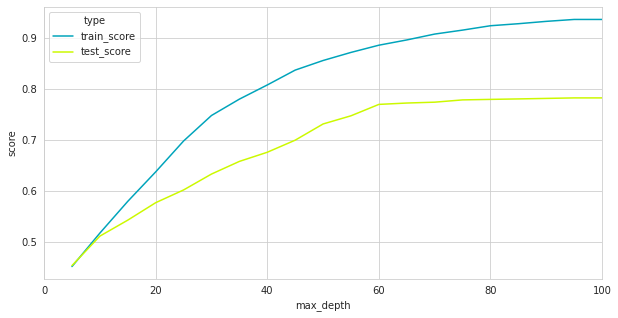

In [46]:
sns.set_style("whitegrid")

fig,ax = plt.subplots(figsize=(10,5))
plot = sns.lineplot(data=scores_data_long,
                    x='max_depth',
                    y='score',
                    hue='type',
                    ax=ax,
                    palette='nipy_spectral')
ax.set(xlim=(0, 100))


In [47]:
plot.figure.savefig('../../../data/angular/images/tree/train_test_pred_score_max_depth_5.png')

In [ ]:
################## looking for the best criterion ##################

In [23]:
criterion_values = ['entropy', 'gini']
scores_data_criterion = pd.DataFrame()

In [24]:
for criterion_value in criterion_values:
    clf = DecisionTreeClassifier(criterion=criterion_value, splitter='best', max_depth=90)
    clf.fit(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    train_score = clf.score(X_train, y_train)

    score_data = pd.DataFrame({'criterion': [criterion_value],
                               'train_score': [train_score],
                               'test_score': [test_score],
                               'predicted_score': [pred_score]})
    scores_data_criterion = scores_data_criterion.append(score_data)
    print(criterion_value)

entropy
gini


In [25]:
scores_data_criterion

,criterion,train_score,test_score,predicted_score
0,entropy,0.932609,0.619879,0.113359
0,gini,0.855788,0.628610,0.094756


In [15]:
################## best estimator ##################

In [5]:
best_clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=80)
best_clf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('hashingvectorizer',
                                                  HashingVectorizer(),
                                                  'file_diff')])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=90))])

In [18]:
test_score = best_clf.score(X_test, y_test)
train_score = best_clf.score(X_train, y_train)

0.6770035395425009

In [20]:
predicted = best_clf.predict(data_test)
pred_score = best_clf.score(data_test, y_data_test)

0.09392286125634614